__Make sure you restart the Python kernel after executing the `pip install` command below__! After you restart the kernel you don't have to execute the command again.

In [21]:
!pip install --user statsmodels

In [22]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Clod Storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [23]:
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [24]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

/tmp/ipykernel_6081/1298107293.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_week = df.resample('w').mean()


,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [25]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,-0.016712
2009-06-21,19.525140,-0.029358
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396


In [26]:
# drop null rows
df_week.dropna(inplace=True)

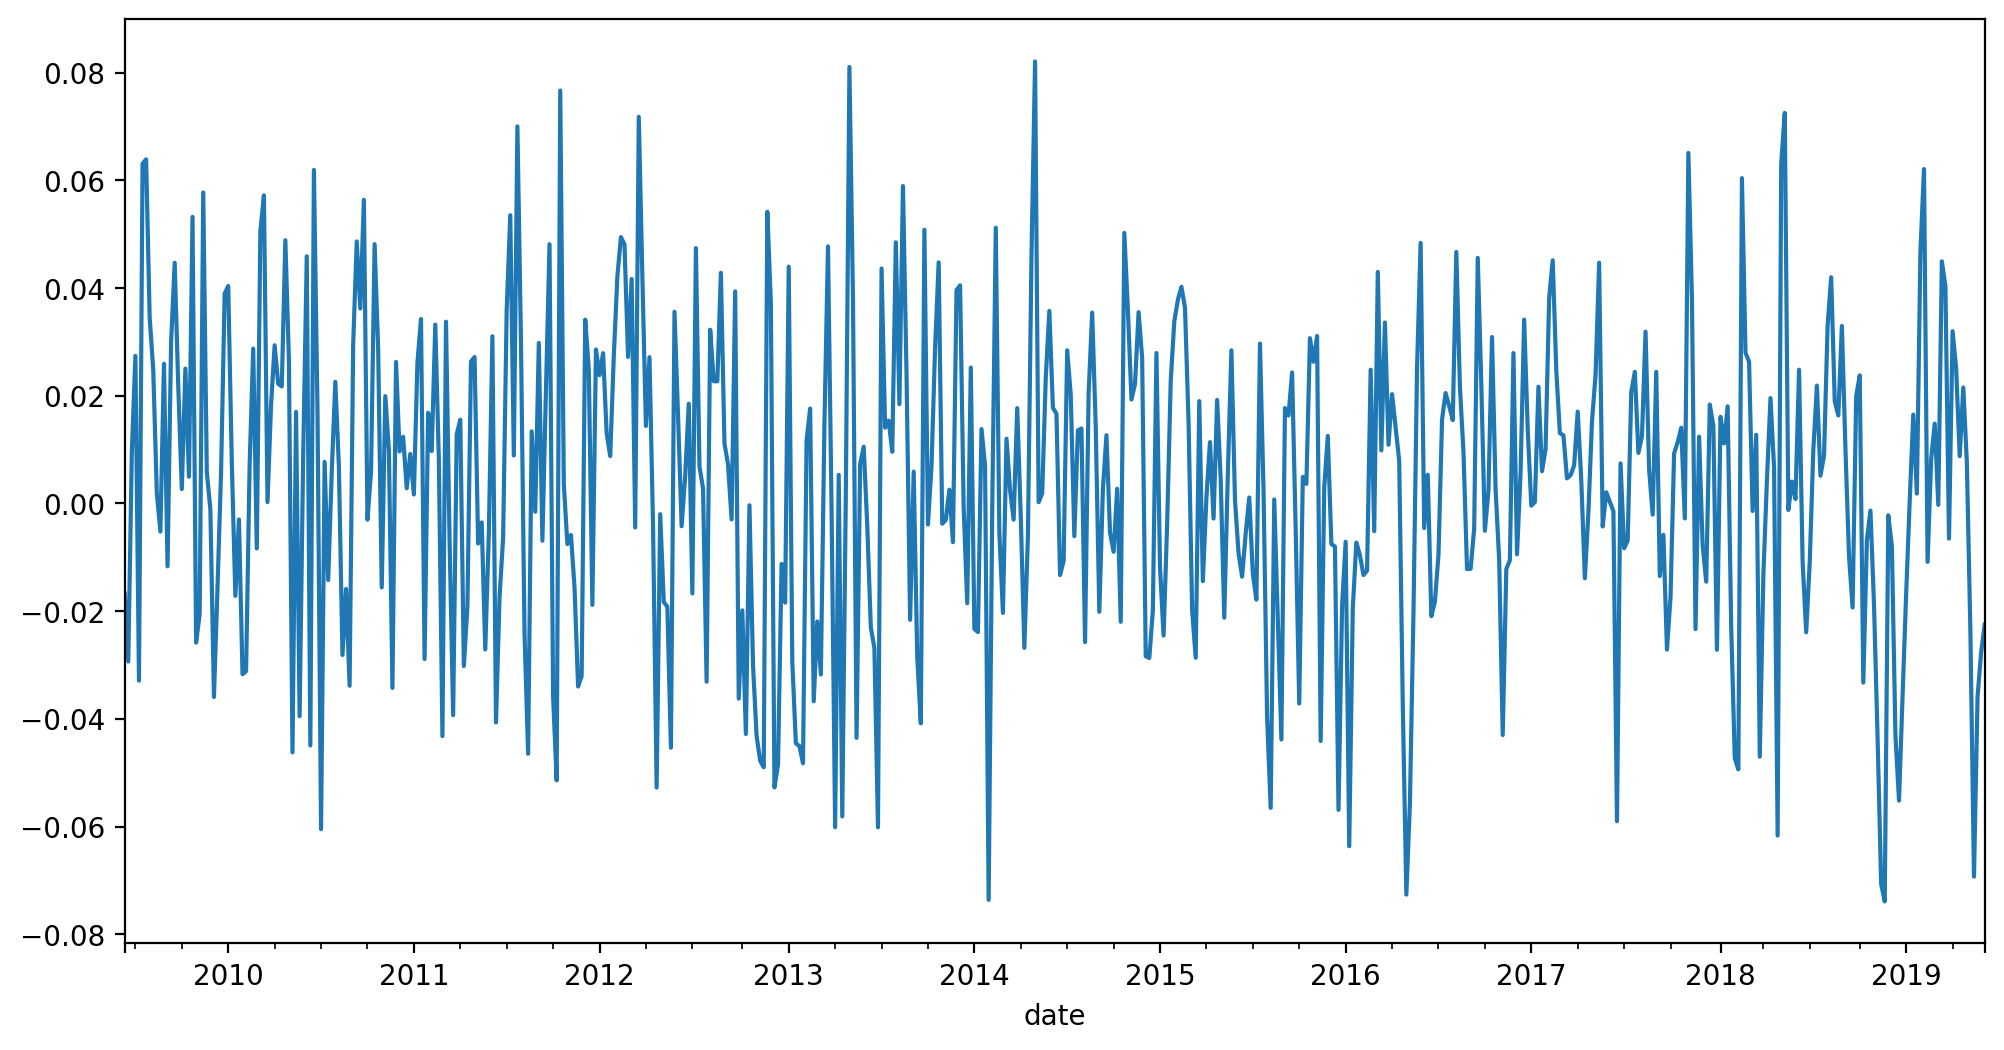

In [27]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [28]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [30]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

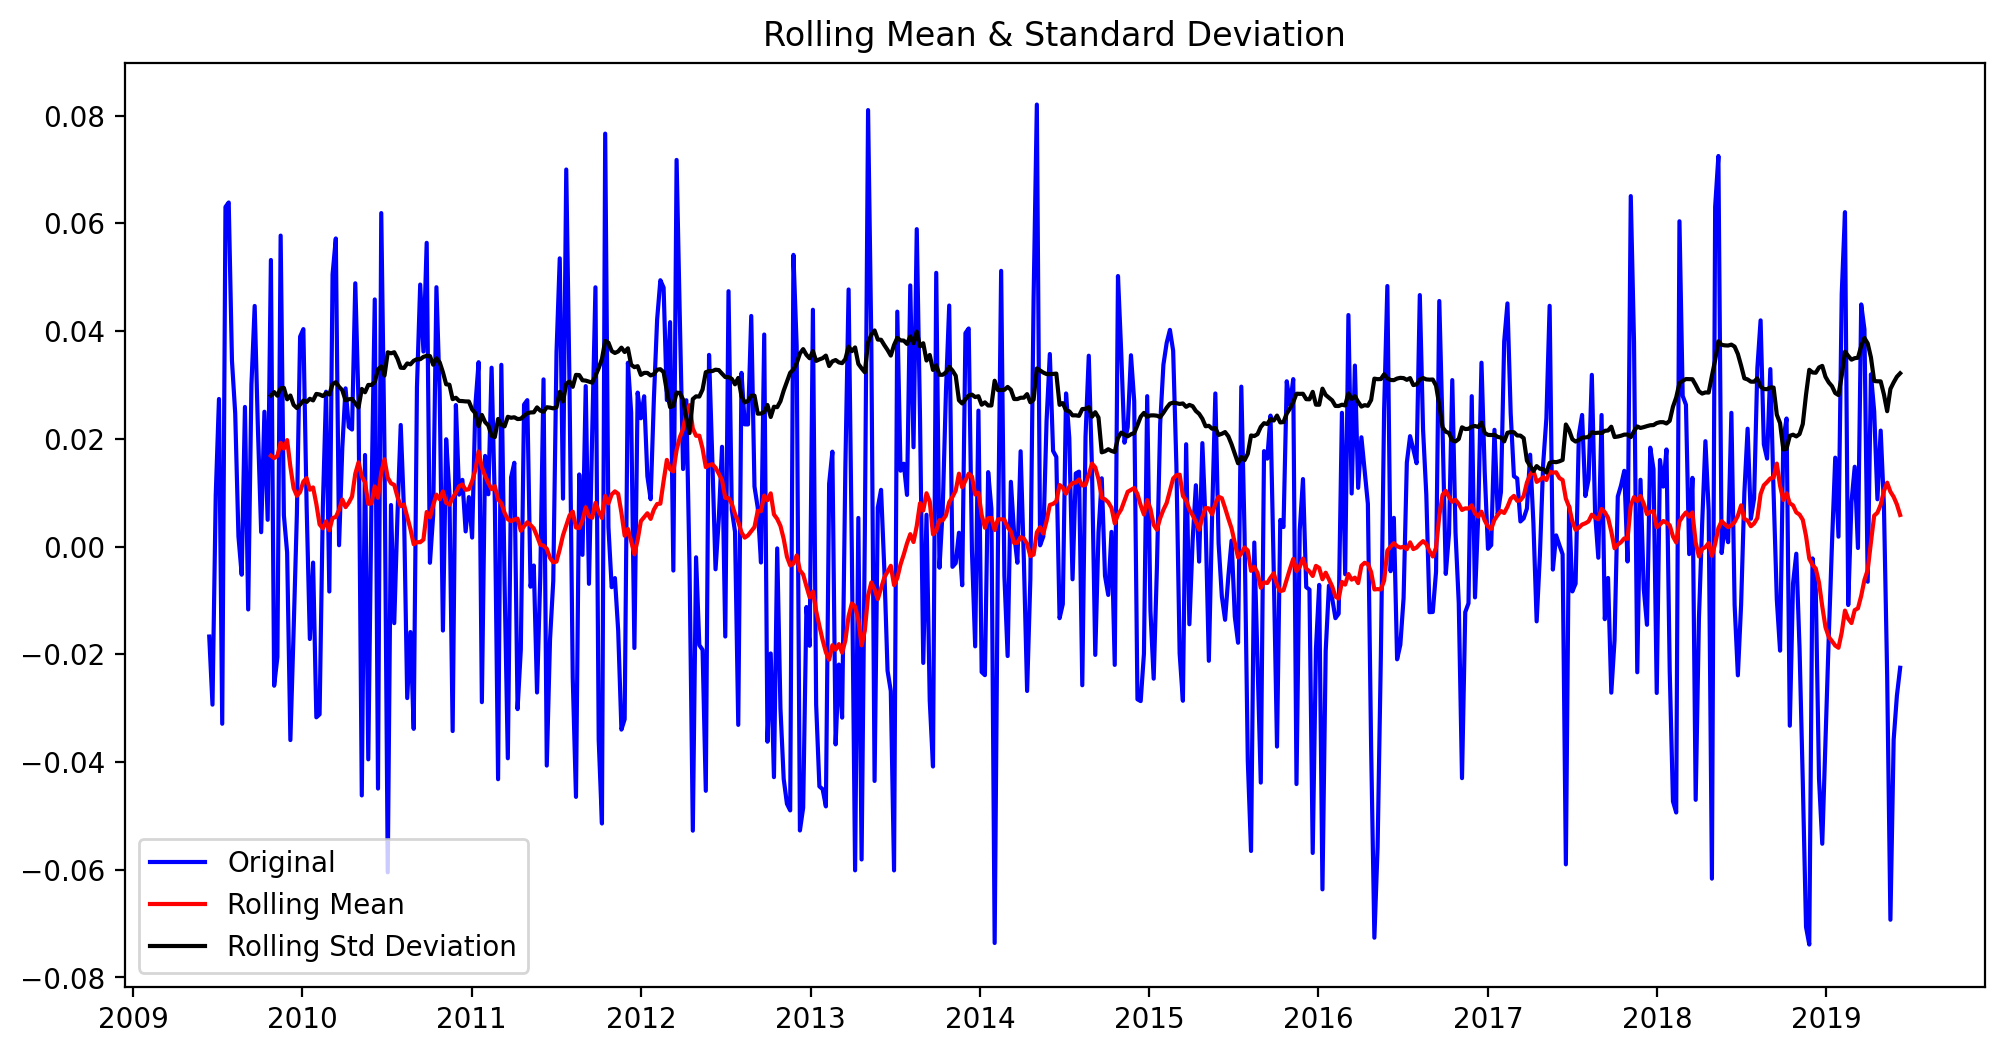

In [31]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [32]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

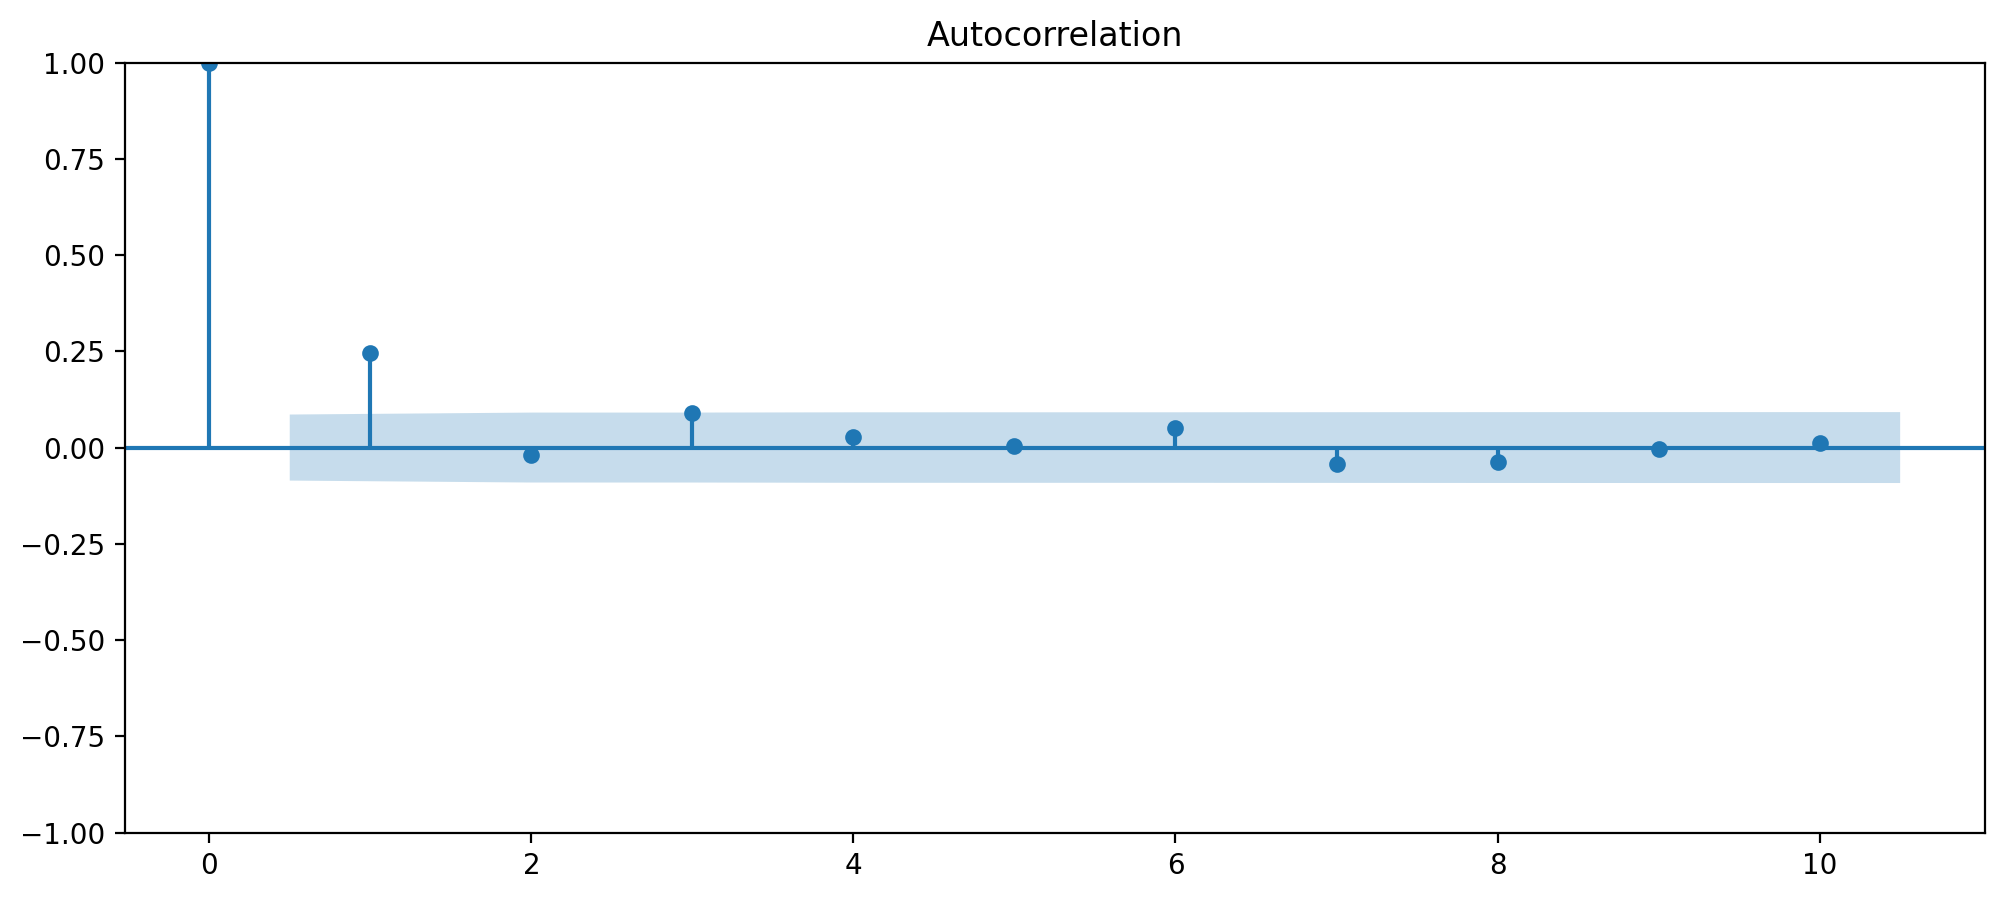

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

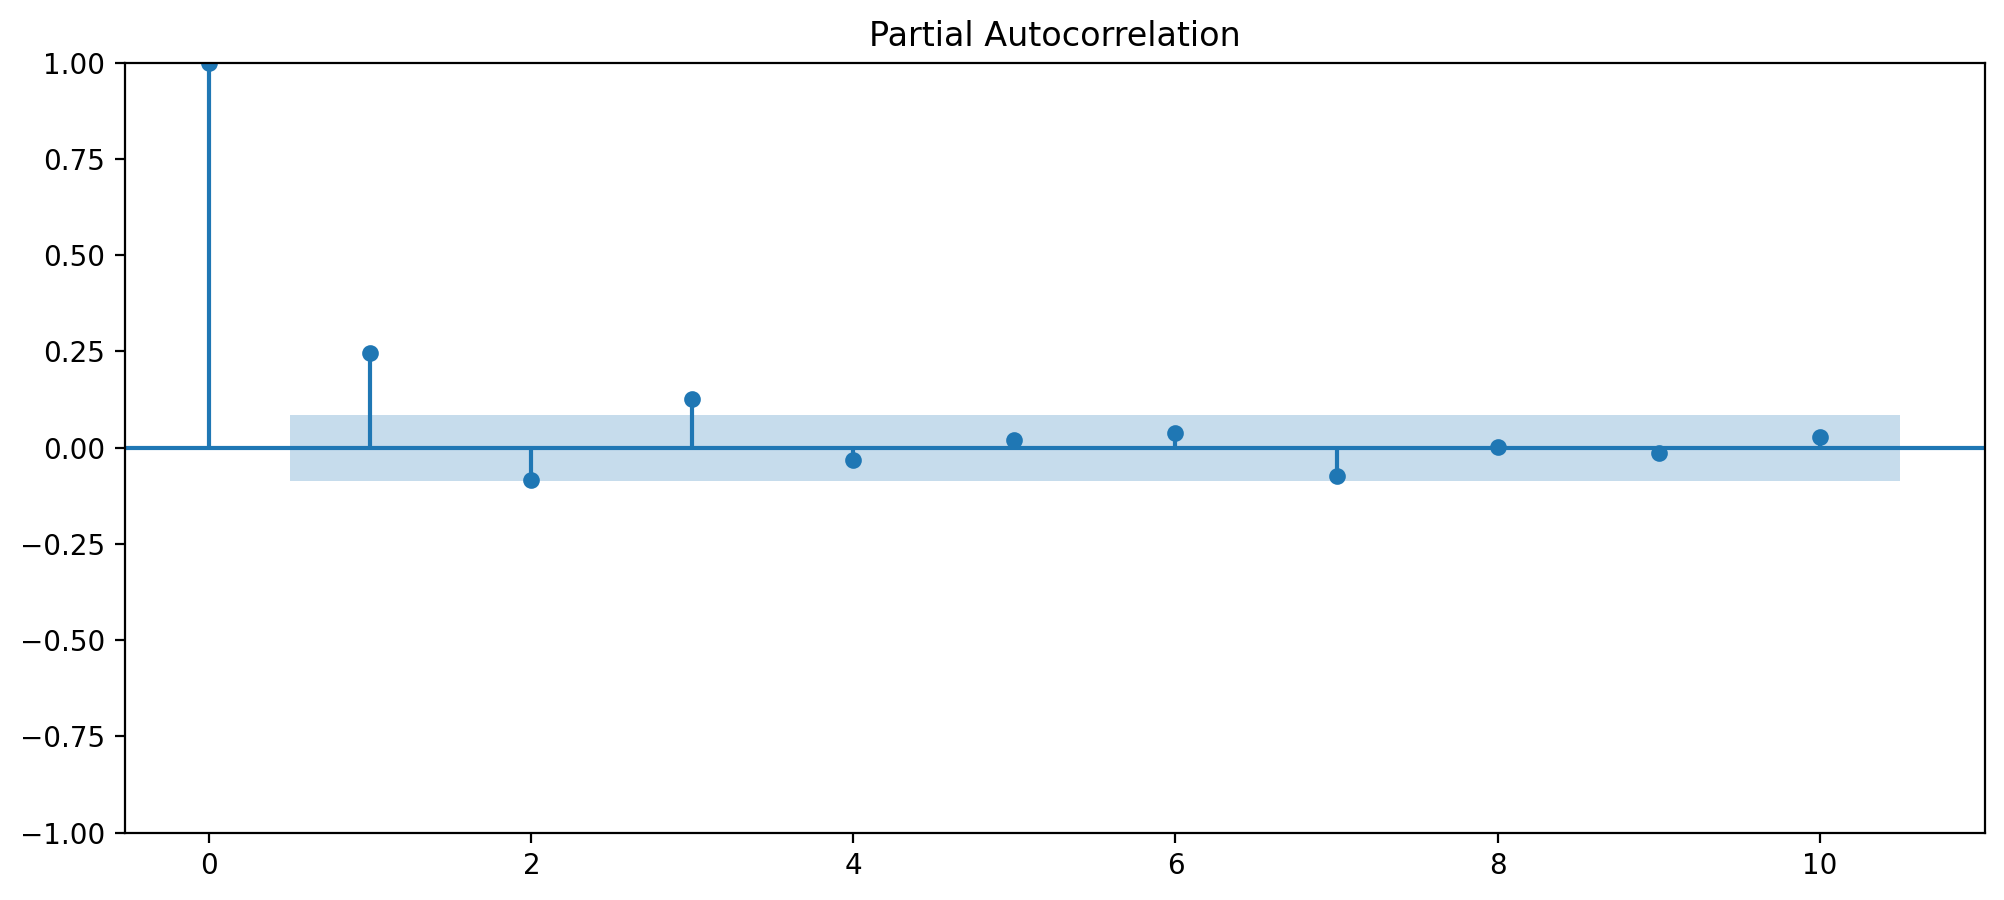

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="../imgs/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

In [35]:
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Define the p, d, and q parameters to take any value between 0 and 3
p = d = q = range(0, 4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# List to store results
results = []

# Grid search for ARIMA hyperparameters
for param in pdq:
    try:
        model = ARIMA(udiff.values, order=param)
        model_fit = model.fit()
        mse = mean_squared_error(udiff.values, model_fit.fittedvalues)
        results.append((param, mse))
        print(f"ARIMA{param} MSE={mse}")
    except Exception as e:
        continue

# Find the best model with minimum MSE
best_model = min(results, key=lambda x: x[1])
print(f"\nBest ARIMA Model: {best_model[0]} with MSE={best_model[1]}")


ARIMA(0, 0, 0) MSE=0.0008362622804879382
ARIMA(0, 0, 1) MSE=0.0007757757100444448
ARIMA(0, 0, 2) MSE=0.0007726874041045513
ARIMA(0, 0, 3) MSE=0.0007693744296741795
ARIMA(0, 1, 0) MSE=0.001258103155503388


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1) MSE=0.000845806854580303
ARIMA(0, 1, 2) MSE=0.000786208290319189


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 3) MSE=0.000782965440051609
ARIMA(0, 2, 0) MSE=0.0033327460189993704
ARIMA(0, 2, 1) MSE=0.0012790510304175667


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) MSE=0.000876146149297279
ARIMA(0, 2, 3) MSE=0.0008175462885542062
ARIMA(0, 3, 0) MSE=0.010188292502832144


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 1) MSE=0.0034009138070664603
ARIMA(0, 3, 2) MSE=0.0013538653484499827


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 3) MSE=0.0009636830836884402
ARIMA(1, 0, 0) MSE=0.0007852438648308245
ARIMA(1, 0, 1) MSE=0.0007717400095059128
ARIMA(1, 0, 2) MSE=0.0007716837841588476
ARIMA(1, 0, 3) MSE=0.0007677759073223118
ARIMA(1, 1, 0) MSE=0.0011252742660547077
ARIMA(1, 1, 1) MSE=0.0007956399835687138


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) MSE=0.0007819438147476182


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 3) MSE=0.000786172367648012
ARIMA(1, 2, 0) MSE=0.0024017280119291774
ARIMA(1, 2, 1) MSE=0.0011452928533263113
ARIMA(1, 2, 2) MSE=0.0012692833906932416
ARIMA(1, 2, 3) MSE=0.0008756873631402389


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 3, 0) MSE=0.006053404802212355
ARIMA(1, 3, 1) MSE=0.0024608228419226064


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 3, 2) MSE=0.0012211009525918775
ARIMA(1, 3, 3) MSE=0.0013513618030831938
ARIMA(2, 0, 0) MSE=0.0007796974981056676


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) MSE=0.0007716295710341229
ARIMA(2, 0, 2) MSE=0.0007697346934256358
ARIMA(2, 0, 3) MSE=0.0007682859546876185
ARIMA(2, 1, 0) MSE=0.0009491742789055985
ARIMA(2, 1, 1) MSE=0.0007901325238743825
ARIMA(2, 1, 2) MSE=0.0007819700027699905


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) MSE=0.0007741619497673806
ARIMA(2, 2, 0) MSE=0.0017067854716526201
ARIMA(2, 2, 1) MSE=0.0009676704674027001


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) MSE=0.0008218250385690856


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) MSE=0.0008755863732672228
ARIMA(2, 3, 0) MSE=0.0037551147890394518


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 3, 1) MSE=0.0017616350604958122


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 3, 2) MSE=0.0010391076397630334
ARIMA(2, 3, 3) MSE=0.001215425079013653
ARIMA(3, 0, 0) MSE=0.0007673775901090587
ARIMA(3, 0, 1) MSE=0.000766689158830358
ARIMA(3, 0, 2) MSE=0.0007666000673694459


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) MSE=0.0007605920170822959
ARIMA(3, 1, 0) MSE=0.0009215744035332609


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1) MSE=0.0007773354145323531


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2) MSE=0.0007796698959749678


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) MSE=0.0007772580948554397
ARIMA(3, 2, 0) MSE=0.0014907149738480616


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 1) MSE=0.0009421299622279516


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 2, 2) MSE=0.000955335713166171


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) MSE=0.0008291667277672831
ARIMA(3, 3, 0) MSE=0.0028927245098201316
ARIMA(3, 3, 1) MSE=0.0015541447712408899


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 3, 2) MSE=0.0017086155259440385


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 3, 3) MSE=0.0010455740309953698

Best ARIMA Model: (3, 0, 3) with MSE=0.0007605920170822959


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [36]:
best_p, best_d, best_q = best_model[0]
best_arima = ARIMA(udiff.values, order=(best_p, best_d, best_q)).fit()
best_arima.summary()


/home/gael55x/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                 ARIMA(3, 0, 3)   Log Likelihood                1133.658
Date:                Sat, 28 Sep 2024   AIC                          -2251.316
Time:                        08:49:13   BIC                          -2217.254
Sample:                             0   HQIC                         -2237.975
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.428      0.015       0.001       0.007
ar.L1         -0.9759      0.574     -1.701      0.089      -2.100       0.148
ar.L2          0.1877      0.735      0.255      0.798      -1.253       1.628
ar.L3          0.2810      0.215      1.304      0.192      -0.141       0.703
ma.L1          1.2718      0.580      2.194      0.028       0.136       2.408
ma.L2          0.0595      0.915      0.065      0.948      -1.734       1.853
ma.L3         -0.3108      0.371     -0.838      0.402      -1.038       0.416
sigma2         0.0008   4.74e-05     16.039      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.92   Prob(JB):                         0.97
Heteroskedasticity (H):               0.75   Skew:                            -0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

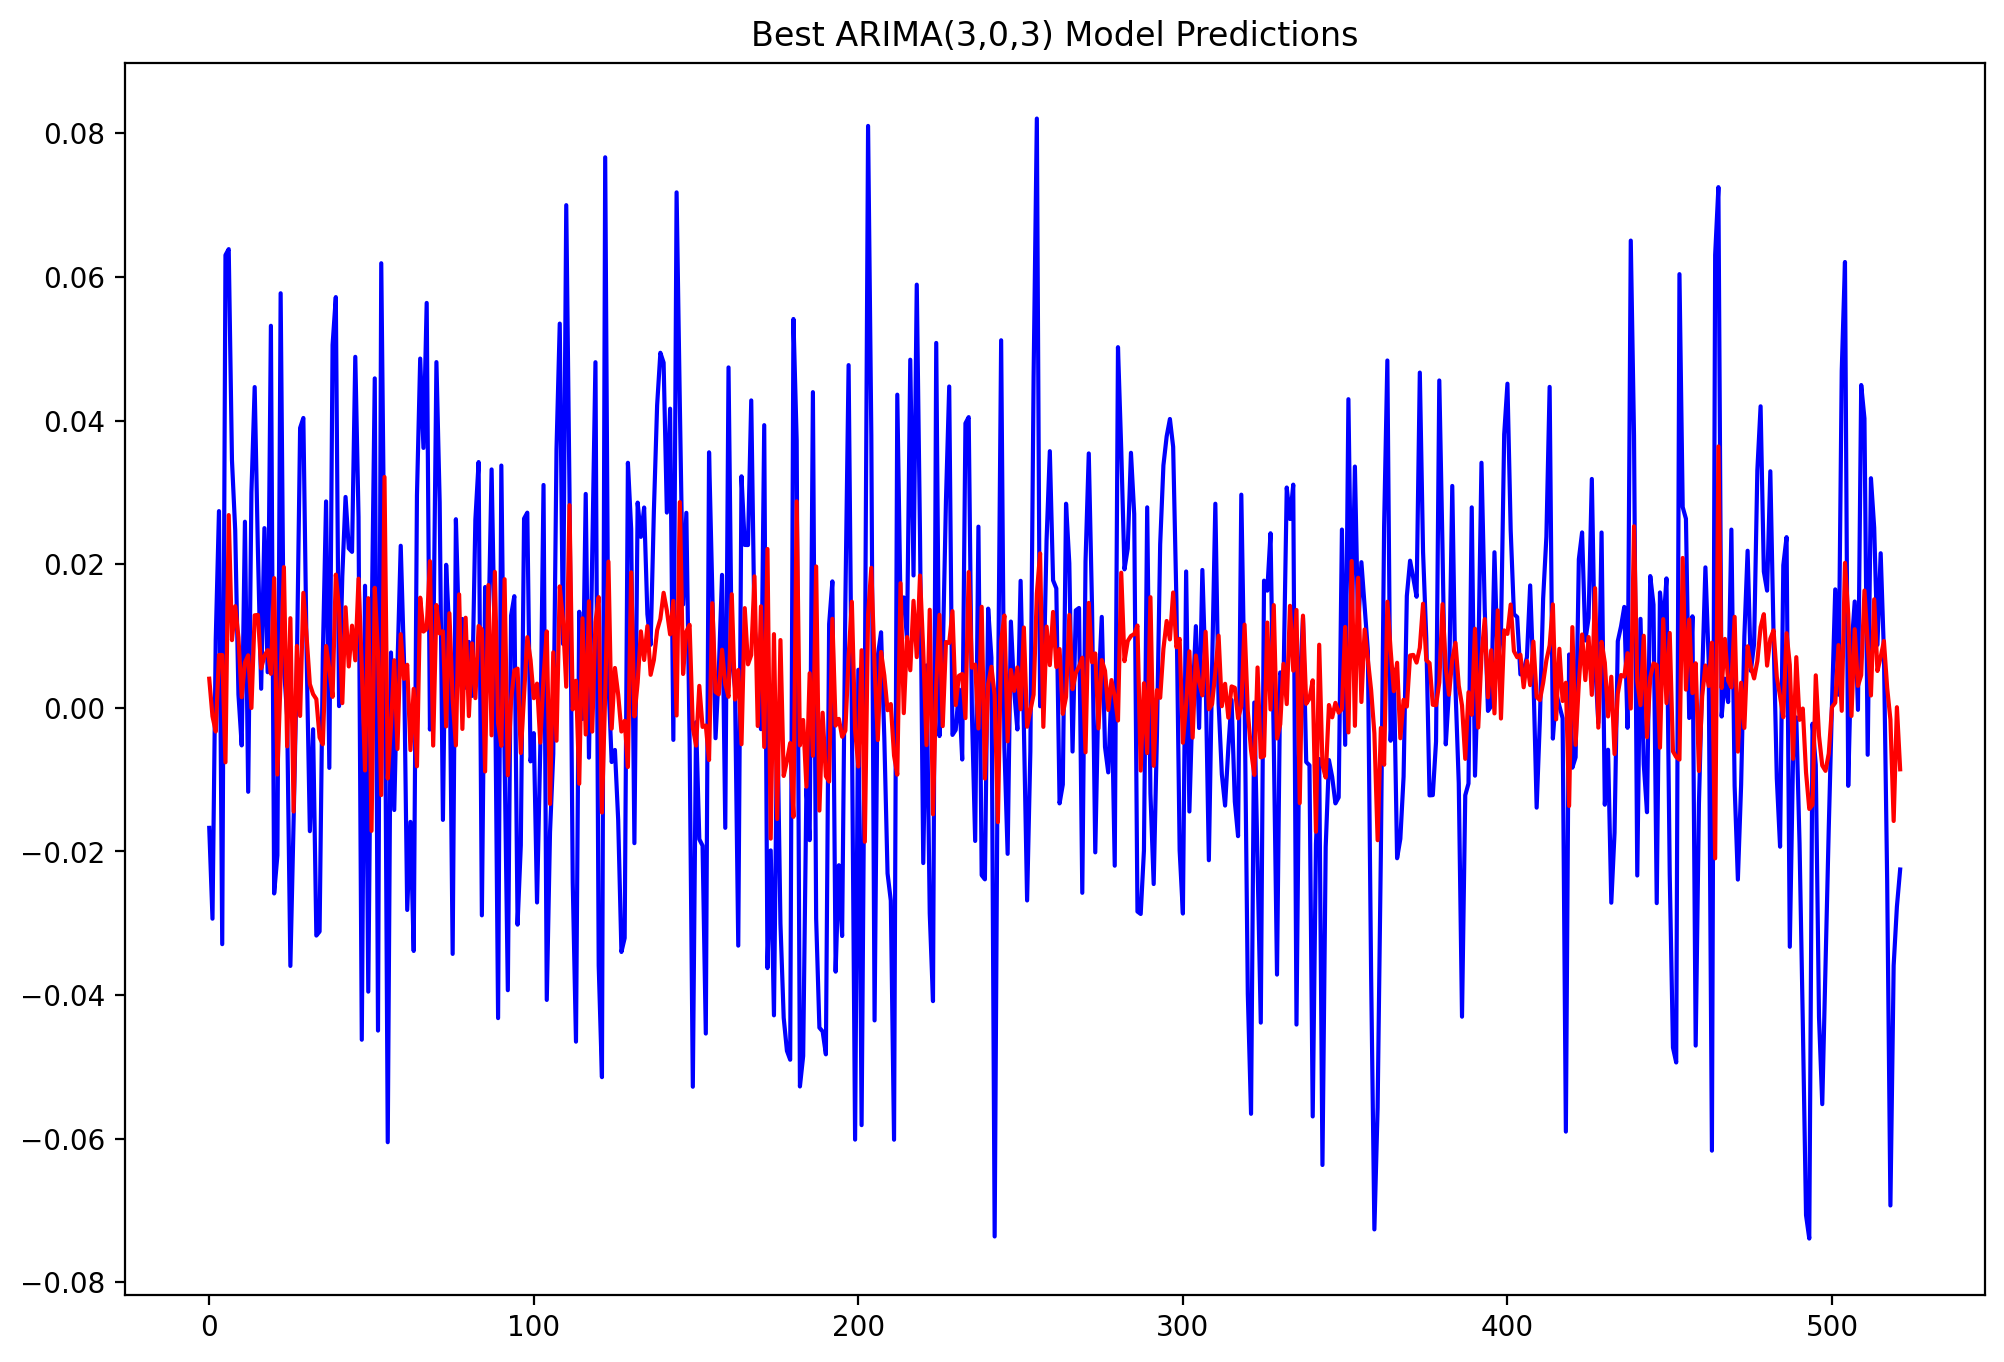

In [37]:
# Plot predictions with the best model
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = best_arima.fittedvalues
plt.plot(preds, color='red')
plt.title(f"Best ARIMA({best_p},{best_d},{best_q}) Model Predictions")
plt.show()

Let's make a forecast 2 weeks ahead:

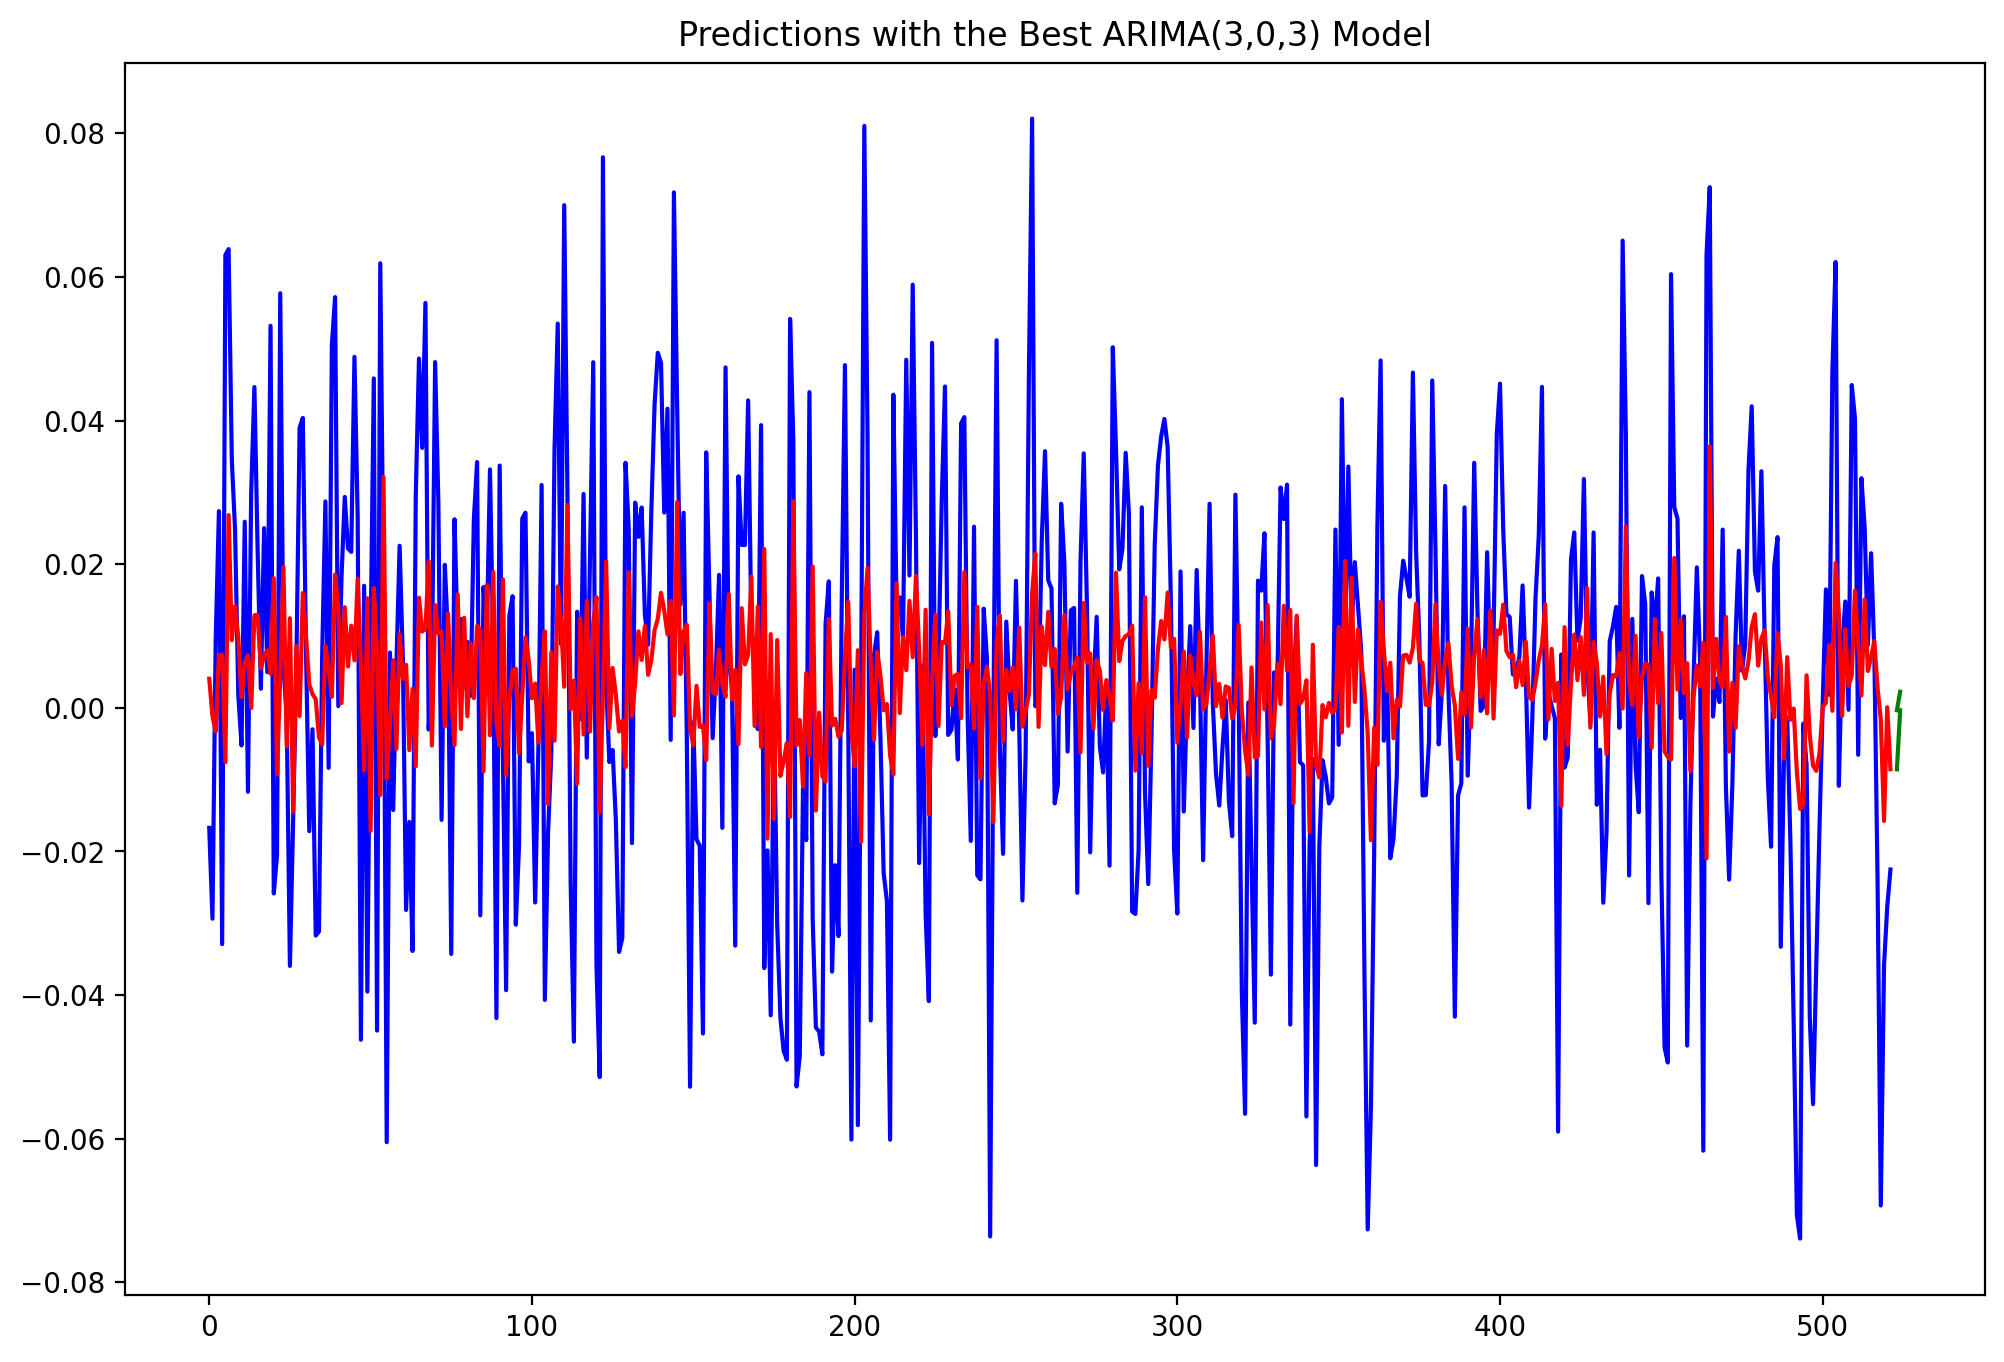

In [38]:
# Forecast the next steps
forecast_steps = 2
forecast = best_arima.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
plt.plot(preds, color='red')
plt.plot(pd.DataFrame(np.array([preds[-1], forecast[0]]).T, index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast, index=range(len(udiff.values)+1, len(udiff.values)+1+forecast_steps)), color='green')
plt.title(f'Predictions with the Best ARIMA({best_p},{best_d},{best_q}) Model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.